In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [4]:
def readLangs(input_file, target_file, input_lang, target_lang, size):
    print("Reading lines...")

    # Read the file and split into lines
    with open(input_file, encoding='utf-8') as file:
        input_lines = [next(file).strip() for x in range(size)]
        
    with open(target_file, encoding='utf-8') as file:
        target_lines = [next(file).strip() for x in range(size)]

    lines = list(zip(input_lines, target_lines))
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l] for l in lines]
    print(pairs[0])

    input_lang = Lang(input_lang)
    target_lang = Lang(target_lang)

    return input_lang, target_lang, pairs

In [5]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 30

def prepareData(input_file, target_file, input_lang, target_lang, size):
    
    input_lang, target_lang, pairs = readLangs(input_file, target_file, input_lang, target_lang, size)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    print(pairs[0])
    for pair in pairs:
        input_lang.addSentence(pair[0])
        target_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(target_lang.name, target_lang.n_words)
    return input_lang, target_lang, pairs

input_file = 'iwslt-vi-en-processed/train.vi'
target_file = 'iwslt-vi-en-processed/train.en'
input_lang, target_lang, pairs = prepareData(input_file, target_file, 'vi', 'eng', size=50000)

Reading lines...
['khoa hoc ang sau mot tieu e ve khi hau', 'rachel pike the science behind a climate headline']
Read 50000 sentence pairs
Trimmed to 37026 sentence pairs
Counting words...
['khoa hoc ang sau mot tieu e ve khi hau', 'rachel pike the science behind a climate headline']
Counted words:
vi 5551
eng 19344


In [6]:
print(pairs[4][0])
print(pairs[4][1])

va tat ca cac trang eu uoc xem xet boi khoa hoc gia va nha phe binh khac tu quoc gia .
and all of those pages were reviewed by another plus scientists and reviewers from countries .


### The Encoder

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        # output and hidden are the same vectors
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training
#### Preparing Training Data

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(target_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

In [10]:
teacher_forcing_ratio = 0.5


# example of input_tensor: [2, 43, 23, 9, 19, 4]. Indexed on our vocabulary. 
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # iterate GRU over words --> final hidden state is representation of source sentence. 
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

In [12]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [13]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

0m 4s (- 30m 30s) (100 0%) 5.5968
0m 7s (- 23m 48s) (200 0%) 5.7728
0m 9s (- 21m 19s) (300 0%) 5.4151
0m 12s (- 19m 50s) (400 1%) 4.8211
0m 14s (- 18m 59s) (500 1%) 4.8875
0m 16s (- 18m 23s) (600 1%) 5.0768
0m 19s (- 17m 55s) (700 1%) 4.8321
0m 21s (- 17m 53s) (800 2%) 5.2649
0m 24s (- 17m 40s) (900 2%) 5.0137
0m 26s (- 17m 28s) (1000 2%) 5.0703
0m 29s (- 17m 22s) (1100 2%) 5.2074
0m 31s (- 17m 11s) (1200 3%) 5.1661
0m 34s (- 17m 4s) (1300 3%) 5.1774
0m 36s (- 16m 55s) (1400 3%) 5.0282
0m 39s (- 16m 50s) (1500 3%) 4.9627
0m 41s (- 16m 44s) (1600 4%) 5.0080
0m 44s (- 16m 40s) (1700 4%) 4.9593
0m 46s (- 16m 30s) (1800 4%) 4.6759
0m 49s (- 16m 24s) (1900 4%) 4.8190
0m 51s (- 16m 19s) (2000 5%) 4.8904
0m 54s (- 16m 16s) (2100 5%) 4.7480
0m 56s (- 16m 12s) (2200 5%) 4.7285
0m 59s (- 16m 8s) (2300 5%) 4.7287
1m 1s (- 16m 4s) (2400 6%) 5.0598
1m 4s (- 16m 0s) (2500 6%) 4.7493
1m 6s (- 15m 59s) (2600 6%) 4.9447
1m 9s (- 15m 57s) (2700 6%) 5.0564
1m 11s (- 15m 54s) (2800 7%) 4.9927
1m 14s (- 15

9m 33s (- 7m 30s) (22400 56%) 4.6210
9m 35s (- 7m 27s) (22500 56%) 4.3865
9m 38s (- 7m 25s) (22600 56%) 4.5847
9m 41s (- 7m 22s) (22700 56%) 4.7381
9m 43s (- 7m 20s) (22800 56%) 4.4532
9m 46s (- 7m 17s) (22900 57%) 4.5935
9m 49s (- 7m 15s) (23000 57%) 4.6728
9m 51s (- 7m 12s) (23100 57%) 4.5673
9m 54s (- 7m 10s) (23200 57%) 4.3248
9m 57s (- 7m 7s) (23300 58%) 4.3180
9m 59s (- 7m 5s) (23400 58%) 4.6260
10m 2s (- 7m 3s) (23500 58%) 4.6635
10m 5s (- 7m 0s) (23600 59%) 4.4617
10m 7s (- 6m 57s) (23700 59%) 4.5282
10m 10s (- 6m 55s) (23800 59%) 4.6344
10m 12s (- 6m 52s) (23900 59%) 4.3259
10m 15s (- 6m 50s) (24000 60%) 4.3940
10m 17s (- 6m 47s) (24100 60%) 4.3862
10m 20s (- 6m 45s) (24200 60%) 4.3457
10m 23s (- 6m 42s) (24300 60%) 4.5836
10m 26s (- 6m 40s) (24400 61%) 4.6074
10m 28s (- 6m 37s) (24500 61%) 4.6000
10m 31s (- 6m 35s) (24600 61%) 4.7515
10m 34s (- 6m 32s) (24700 61%) 4.3044
10m 36s (- 6m 30s) (24800 62%) 4.5589
10m 39s (- 6m 27s) (24900 62%) 4.6115
10m 42s (- 6m 25s) (25000 62%)

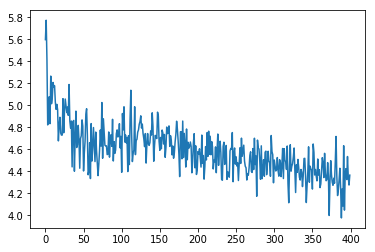

In [44]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(target_lang.n_words, hidden_size).to(device)

num_iters = 40000
trainIters(encoder1, decoder1, num_iters, print_every=100)

In [46]:
# torch.save(encoder1.state_dict(), "encoder1_40000")
# torch.save(decoder1.state_dict(), "decoder1_40000")

In [45]:
evaluateRandomly(encoder1, decoder1)

> nhung chung ta co the thay oi cach hieu cua no theo thoi gian va nien ai khac nhau trong thoi ki trung co .
= but we can change how it was interpreted because it was interpreted according to the time and milieu in the middle ages .
< but we can see it it to and and that EOS

> toi thay rat phan khoi . toi i cung ong ay toi phong lam viec .
= i was very excited . i walked with him to his office .
< i m very to . . . . . . . . . EOS

> chang la la oi boi bac si la nguoi gap vo van nhung van e ma ho khong ngo la co giai phap .
= this makes no sense because physicians have all kinds of problems that they don t realize have solutions .
< and the not is not to the only that is to . EOS

> ten ong ay la lothar lothar meggendorfer .
= his name was lothar lothar meggendorfer .
< he s the that . . . . EOS

>  khi toi ra khoi may bay voi ay u nhien lieu toi nang khoang ky .
= yr when i exit full of kerosene i m about kilos .
< i when i i to with this EOS

> bao nhieu nguoi o ay giong nhu vay ? 

In [40]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Randomly select a English sentence from the dataset and try to produce its French translation.
    Note that you need a correct implementation of evaluate() in order to make this function work.
    """    
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = generate_translation(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [38]:
def generate_translation(encoder, decoder, sentence, max_length=MAX_LENGTH, search="greedy"):
    """ 
    Softmax over vocabulary, and either do greedy search or beam search. 
    
    @param max_length: the max # of words that the decoder can return
    @returns decoded_words: a list of words in target language
    """    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        # encode the source sentence
        encoder_hidden = encoder.initHidden()
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        # start decoding
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []
        
        if search == 'greedy':
            decoded_words = greedy_search(decoder, decoder_input, decoder_hidden, max_length)
        elif search == 'beam':
            decoded_words = beam_search(decoder, decoder_input, decoder_hidden, max_length)  

        return decoded_words

In [37]:
def greedy_search(decoder, decoder_input, hidden, max_length):
    
    translation = []
    for i in range(max_length):
        next_word_softmax, hidden = decoder(decoder_input, hidden)
        best_idx = torch.max(next_word_softmax, 1)[1].squeeze().item()

        # convert idx to word
        best_word = target_lang.index2word[best_idx]
        translation.append(best_word)
        decoder_input = torch.tensor([[best_idx]], device=device)
        
        if best_word == 'EOS':
            break
    return translation


def beam_search(decoder, decoder_input, hidden, max_length, k = 2):
    
    candidates = [(decoder_input, 1, hidden)]
    potential_candidates = []
    completed_translations = []

    # put a cap on the length of generated sentences
    for m in range(max_length):
        for c in candidates:
            # unpack the tuple
            c_sequence = c[0]
            c_score = c[1]
            c_hidden = c[2]
            # EOS token
            if c_sequence[-1] == 1:
                completed_translations.append((c_sequence, c_score))
                k = k - 1
            else:
                next_word_probs, hidden = decoder(c_sequence[-1], c_hidden)
                # in the worst-case, one sequence will have the highest k probabilities
                # so to save computation, only grab the k highest_probability from each candidate sequence
                top_probs, top_idx = torch.topk(next_word_probs, k)
                for i in range(len(top_probs)):
                    potential_candidates.append((sequence+[top_idx[i]], score*top_probs[i], hidden))

        candidates = sorted(potential_candidates, key= lambda x: x[1])[0:k] 
        potential_candidates = []

    completed = completed_translations + candidates
    final_translation = sorted(completed, key= lambda x: x[1])[0] 
    return final_translation[0]

TODO: 
    
Why is encoder final hidden state used as translation decoder hidden state initialization? 